# Evaluation Graphics
This notebook compares evaluation metrics from `results_ground_truth.csv` and `results_rag.csv`.
The goal is to visualize how the RAG approach performs across precision, recall and ROUGE metrics for each question and each paper.

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
sns.set(style='whitegrid')

In [6]:
# Load the csv files
base = Path('')
rag = pd.read_csv(base / 'results_rag.csv')
gt = pd.read_csv(base / 'results_ground_truth.csv')
metric_cols = ['precision-1','recall-1','ROUGE-1','precision-2','recall-2','ROUGE-2']

In [7]:
# Extract document and question information
def add_doc_question(df):
    df['document'] = df['question_id'].str.split('_').str[0]
    df['question'] = df['question_id'].str.split('_').str[1:].str.join('_')
    return df

rag = add_doc_question(rag)
gt = add_doc_question(gt)

In [8]:
# Merge dataframes for comparison
merged = rag[['question_id','document','question'] + metric_cols].merge(
    gt[['question_id'] + metric_cols], on='question_id', suffixes=('_rag','_gt'))

for col in metric_cols:
    merged[f'{col}_diff'] = merged[f'{col}_rag'] - merged[f'{col}_gt']

merged.head()

,question_id,document,question,precision-1_rag,recall-1_rag,ROUGE-1_rag,precision-2_rag,recall-2_rag,ROUGE-2_rag,precision-1_gt,...,ROUGE-1_gt,precision-2_gt,recall-2_gt,ROUGE-2_gt,precision-1_diff,recall-1_diff,ROUGE-1_diff,precision-2_diff,recall-2_diff,ROUGE-2_diff
0,P1_Q1,P1,Q1,0.115152,0.246753,0.157025,0.018293,0.039474,0.025000,0.094262,...,0.143302,0.012346,0.039474,0.018809,0.020889,-0.051948,0.013723,0.005947,0.000000,0.006191
1,P1_Q2,P1,Q2,0.187500,0.313953,0.234783,0.020979,0.035294,0.026316,0.153005,...,0.208178,0.027473,0.058824,0.037453,0.034495,-0.011628,0.026604,-0.006494,-0.023529,-0.011137
2,P1_Q3,P1,Q3,0.169811,0.095745,0.122449,0.000000,0.000000,0.000000,0.148148,...,0.108108,0.000000,0.000000,0.000000,0.021663,0.010638,0.014341,0.000000,0.000000,0.000000
3,P1_Q4,P1,Q4,0.203883,0.262500,0.229508,0.039216,0.050633,0.044199,0.338028,...,0.317881,0.128571,0.113924,0.120805,-0.134145,-0.037500,-0.088373,-0.089356,-0.063291,-0.076606
4,P1_Q5,P1,Q5,0.172414,0.116279,0.138889,0.017544,0.011765,0.014085,0.189655,...,0.152778,0.017544,0.011765,0.014085,-0.017241,-0.011628,-0.013889,0.000000,0.000000,0.000000


## Heatmap of Metric Improvements
Each cell shows the improvement (RAG minus Ground Truth) for a metric/question pair.

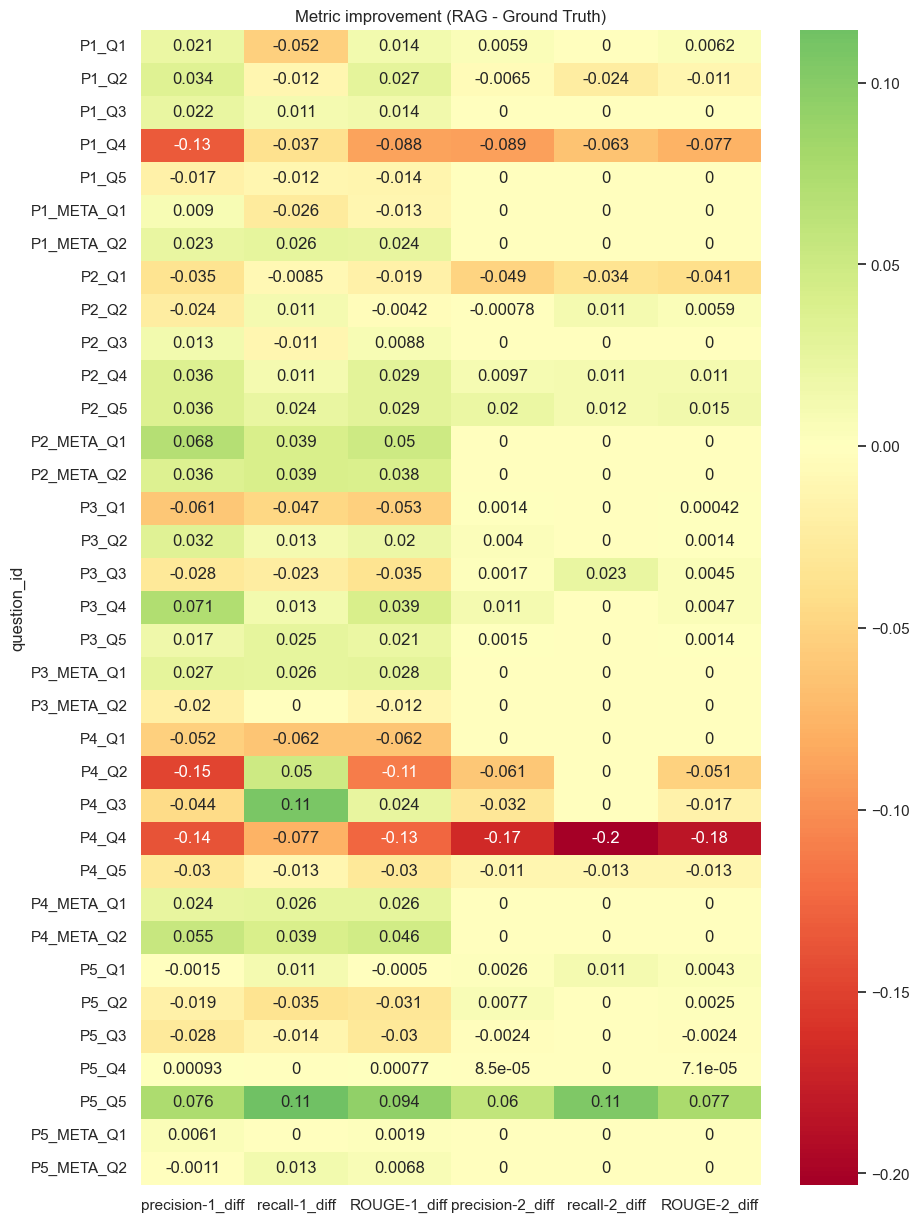

In [9]:
def plot_improvement_heatmap(df):
    heat_data = df.set_index('question_id')[[c + '_diff' for c in metric_cols]]
    plt.figure(figsize=(10, len(df)*0.4 + 1))
    sns.heatmap(heat_data, annot=True, cmap='RdYlGn', center=0)
    plt.title('Metric improvement (RAG - Ground Truth)')
    plt.show()

plot_improvement_heatmap(merged)

## Bar Chart by Question
Compare each metric for RAG and Ground Truth for a specific question.

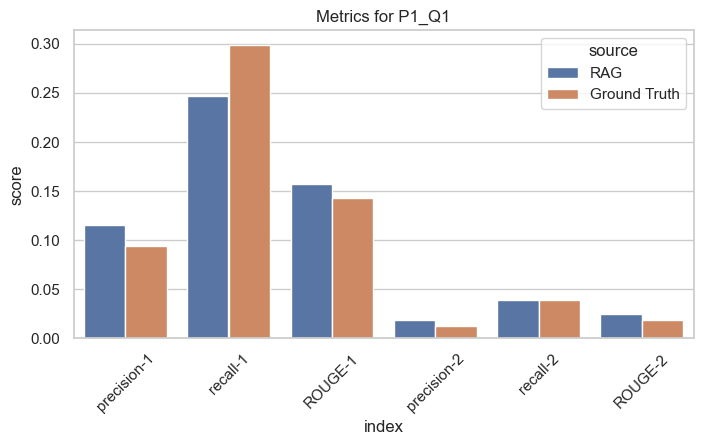

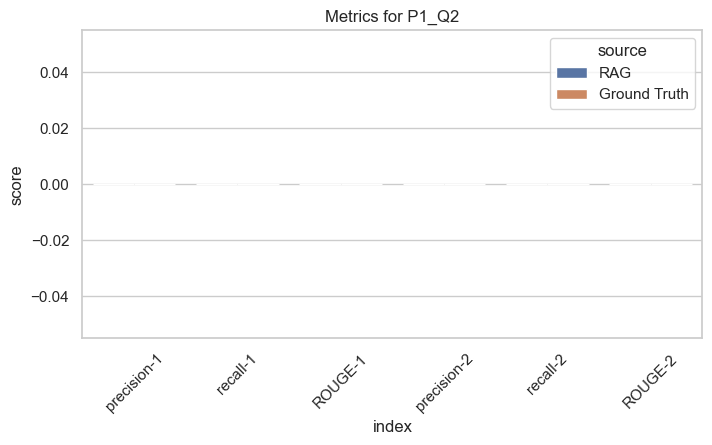

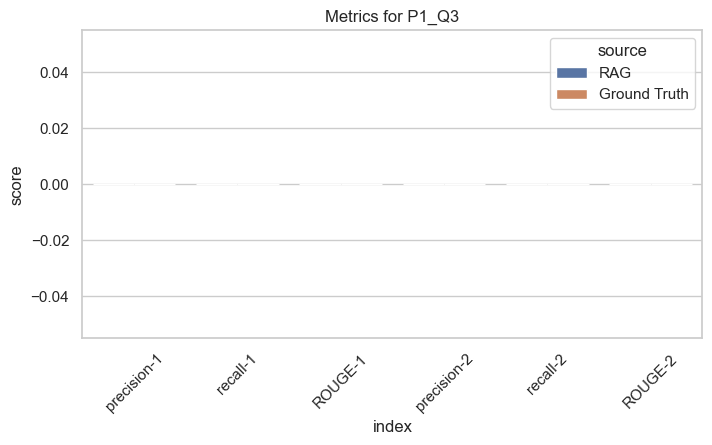

In [10]:
def plot_question_metrics(df, qid):
    data = df[df['question_id'] == qid]
    to_plot = data[[m + '_rag' for m in metric_cols] + [m + '_gt' for m in metric_cols]].T
    to_plot.index = metric_cols * 2
    to_plot['source'] = ['RAG']*len(metric_cols) + ['Ground Truth']*len(metric_cols)
    plt.figure(figsize=(8,4))
    sns.barplot(x='index', y=0, hue='source', data=to_plot.reset_index())
    plt.title(f'Metrics for {qid}')
    plt.xticks(rotation=45)
    plt.ylabel('score')
    plt.show()

_ = [plot_question_metrics(merged, q) for q in merged['question_id'].unique()[:3]]  # example

## Mean Metrics per Document
Aggregated metrics are averaged per paper (P1-P5).

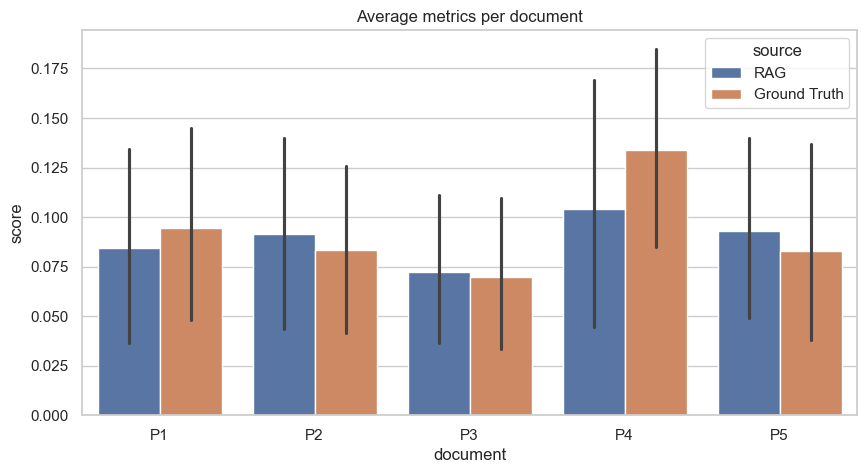

In [11]:
def plot_document_means(df):
    means = df.groupby('document')[[c + '_rag' for c in metric_cols] + [c + '_gt' for c in metric_cols]].mean()
    melted = means.reset_index().melt(id_vars='document', var_name='metric', value_name='score')
    melted['source'] = melted['metric'].apply(lambda x: 'RAG' if x.endswith('_rag') else 'Ground Truth')
    melted['metric'] = melted['metric'].str.replace('_rag','').str.replace('_gt','')
    plt.figure(figsize=(10,5))
    sns.barplot(data=melted, x='document', y='score', hue='source')
    plt.title('Average metrics per document')
    plt.show()

plot_document_means(merged)

## Boxplot of Improvements by Document


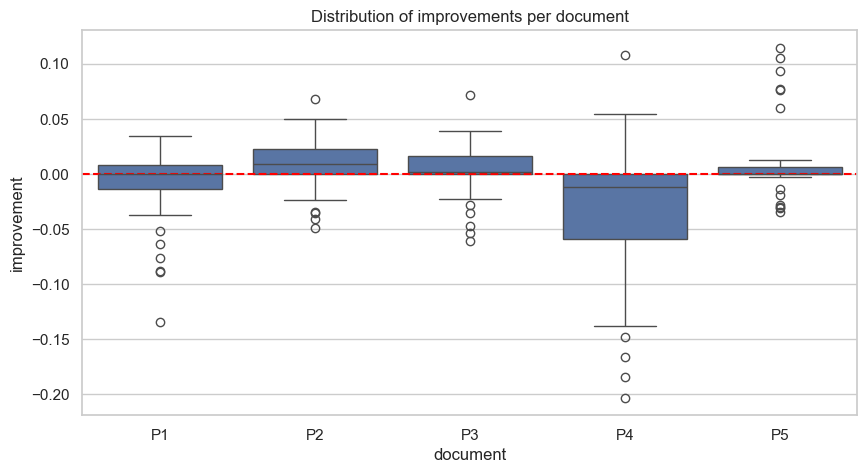

In [12]:
def plot_improvement_boxplot(df):
    diff_cols = [c + '_diff' for c in metric_cols]
    melted = df.melt(id_vars='document', value_vars=diff_cols, var_name='metric', value_name='improvement')
    plt.figure(figsize=(10,5))
    sns.boxplot(data=melted, x='document', y='improvement')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Distribution of improvements per document')
    plt.show()

plot_improvement_boxplot(merged)